# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

     |████████████████████████████████| 509 kB 17.3 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

     |████████████████████████████████| 188 kB 27.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

     |████████████████████████████████| 147 kB 21.2 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

     |████████████████████████████████| 54 kB 3.5 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.gp28 # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [4]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [9]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [10]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5246403,-77.5633017,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [11]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Sun Nov 22 15:09:34 +0000 2020'
'Sun Nov 22 15:09:18 +0000 2020'
'Sun Nov 22 15:08:45 +0000 2020'
'Sun Nov 22 15:08:05 +0000 2020'
'Sun Nov 22 15:07:53 +0000 2020'
'Sun Nov 22 15:07:46 +0000 2020'
'Sun Nov 22 15:06:54 +0000 2020'
'Sun Nov 22 15:06:41 +0000 2020'
'Sun Nov 22 15:06:31 +0000 2020'
'Sun Nov 22 15:06:02 +0000 2020'
'Sun Nov 22 15:05:59 +0000 2020'
'Sun Nov 22 15:05:39 +0000 2020'
'Sun Nov 22 15:05:32 +0000 2020'
'Sun Nov 22 15:05:08 +0000 2020'
'Sun Nov 22 15:05:04 +0000 2020'
'Sun Nov 22 15:04:48 +0000 2020'
'Sun Nov 22 15:04:45 +0000 2020'
'Sun Nov 22 15:04:28 +0000 2020'
'Sun Nov 22 15:04:15 +0000 2020'
'Sun Nov 22 15:03:35 +0000 2020'
'Sun Nov 22 15:03:34 +0000 2020'
'Sun Nov 22 15:03:27 +0000 2020'
'Sun Nov 22 15:03:23 +0000 2020'
'Sun Nov 22 15:03:19 +0000 2020'
'Sun Nov 22 15:02:02 +0000 2020'
'Sun Nov 22 15:01:59 +0000 2020'
'Sun Nov 22 15:01:35 +0000 2020'
'Sun Nov 22 15:01:31 +0000 2020'
'Sun Nov 22 15:01:29 +0000 2020'
'Sun Nov 22 15:01:29 +0000 2020'
'Sun Nov 2

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [14]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Sat Nov 21 15:23:01 +0000 2020'
'Sat Nov 21 15:23:00 +0000 2020'
'Sat Nov 21 15:22:56 +0000 2020'
'Sat Nov 21 15:22:55 +0000 2020'
'Sat Nov 21 15:22:50 +0000 2020'
'Sat Nov 21 15:22:41 +0000 2020'
'Sat Nov 21 15:22:28 +0000 2020'
'Sat Nov 21 15:22:15 +0000 2020'
'Sat Nov 21 15:22:15 +0000 2020'
'Sat Nov 21 15:22:13 +0000 2020'
'Sat Nov 21 15:21:50 +0000 2020'
'Sat Nov 21 15:21:48 +0000 2020'
'Sat Nov 21 15:21:41 +0000 2020'
'Sat Nov 21 15:21:34 +0000 2020'
'Sat Nov 21 15:21:07 +0000 2020'
'Sat Nov 21 15:21:04 +0000 2020'
'Sat Nov 21 15:20:58 +0000 2020'
'Sat Nov 21 15:20:53 +0000 2020'
'Sat Nov 21 15:20:52 +0000 2020'
'Sat Nov 21 15:20:49 +0000 2020'
'Sat Nov 21 15:20:40 +0000 2020'
'Sat Nov 21 15:20:12 +0000 2020'
'Sat Nov 21 15:20:03 +0000 2020'
'Sat Nov 21 15:19:54 +0000 2020'
'Sat Nov 21 15:19:51 +0000 2020'
'Sat Nov 21 15:19:48 +0000 2020'
'Sat Nov 21 15:19:15 +0000 2020'
'Sat Nov 21 15:19:01 +0000 2020'
'Sat Nov 21 15:18:52 +0000 2020'
'Sat Nov 21 15:18:40 +0000 2020'
'Sat Nov 2

'Sat Nov 21 14:36:15 +0000 2020'
'Sat Nov 21 14:35:49 +0000 2020'
'Sat Nov 21 14:35:37 +0000 2020'
'Sat Nov 21 14:35:03 +0000 2020'
'Sat Nov 21 14:35:00 +0000 2020'
'Sat Nov 21 14:34:44 +0000 2020'
'Sat Nov 21 14:34:43 +0000 2020'
'Sat Nov 21 14:34:08 +0000 2020'
'Sat Nov 21 14:33:54 +0000 2020'
'Sat Nov 21 14:33:08 +0000 2020'
'Sat Nov 21 14:32:58 +0000 2020'
'Sat Nov 21 14:32:43 +0000 2020'
'Sat Nov 21 14:32:39 +0000 2020'
'Sat Nov 21 14:32:26 +0000 2020'
'Sat Nov 21 14:32:26 +0000 2020'
'Sat Nov 21 14:32:19 +0000 2020'
'Sat Nov 21 14:32:02 +0000 2020'
'Sat Nov 21 14:31:50 +0000 2020'
'Sat Nov 21 14:30:55 +0000 2020'
'Sat Nov 21 14:30:47 +0000 2020'
'Sat Nov 21 14:30:43 +0000 2020'
'Sat Nov 21 14:30:12 +0000 2020'
'Sat Nov 21 14:30:09 +0000 2020'
'Sat Nov 21 14:30:03 +0000 2020'
'Sat Nov 21 14:30:02 +0000 2020'
'Sat Nov 21 14:29:45 +0000 2020'
'Sat Nov 21 14:29:42 +0000 2020'
'Sat Nov 21 14:29:35 +0000 2020'
'Sat Nov 21 14:29:20 +0000 2020'
'Sat Nov 21 14:29:01 +0000 2020'
'Sat Nov 2

'Sat Nov 21 13:31:37 +0000 2020'
'Sat Nov 21 13:31:19 +0000 2020'
'Sat Nov 21 13:31:02 +0000 2020'
'Sat Nov 21 13:31:01 +0000 2020'
'Sat Nov 21 13:30:44 +0000 2020'
'Sat Nov 21 13:30:39 +0000 2020'
'Sat Nov 21 13:30:26 +0000 2020'
'Sat Nov 21 13:30:10 +0000 2020'
'Sat Nov 21 13:30:04 +0000 2020'
'Sat Nov 21 13:30:00 +0000 2020'
'Sat Nov 21 13:29:42 +0000 2020'
'Sat Nov 21 13:29:11 +0000 2020'
'Sat Nov 21 13:28:29 +0000 2020'
'Sat Nov 21 13:27:32 +0000 2020'
'Sat Nov 21 13:27:27 +0000 2020'
'Sat Nov 21 13:26:40 +0000 2020'
'Sat Nov 21 13:26:29 +0000 2020'
'Sat Nov 21 13:26:00 +0000 2020'
'Sat Nov 21 13:25:39 +0000 2020'
'Sat Nov 21 13:25:06 +0000 2020'
'Sat Nov 21 13:24:56 +0000 2020'
'Sat Nov 21 13:24:55 +0000 2020'
'Sat Nov 21 13:24:51 +0000 2020'
'Sat Nov 21 13:24:09 +0000 2020'
'Sat Nov 21 13:24:01 +0000 2020'
'Sat Nov 21 13:22:42 +0000 2020'
'Sat Nov 21 13:22:10 +0000 2020'
'Sat Nov 21 13:21:51 +0000 2020'
'Sat Nov 21 13:21:51 +0000 2020'
'Sat Nov 21 13:21:31 +0000 2020'
'Sat Nov 2

'Sat Nov 21 11:17:51 +0000 2020'
'Sat Nov 21 11:17:48 +0000 2020'
'Sat Nov 21 11:17:20 +0000 2020'
'Sat Nov 21 11:17:20 +0000 2020'
'Sat Nov 21 11:17:10 +0000 2020'
'Sat Nov 21 11:16:20 +0000 2020'
'Sat Nov 21 11:15:40 +0000 2020'
'Sat Nov 21 11:15:07 +0000 2020'
'Sat Nov 21 11:14:52 +0000 2020'
'Sat Nov 21 11:14:08 +0000 2020'
'Sat Nov 21 11:13:56 +0000 2020'
'Sat Nov 21 11:13:50 +0000 2020'
'Sat Nov 21 11:13:00 +0000 2020'
'Sat Nov 21 11:12:42 +0000 2020'
'Sat Nov 21 11:12:28 +0000 2020'
'Sat Nov 21 11:12:18 +0000 2020'
'Sat Nov 21 11:12:14 +0000 2020'
'Sat Nov 21 11:12:09 +0000 2020'
'Sat Nov 21 11:11:18 +0000 2020'
'Sat Nov 21 11:10:04 +0000 2020'
'Sat Nov 21 11:06:46 +0000 2020'
'Sat Nov 21 11:05:19 +0000 2020'
'Sat Nov 21 11:03:15 +0000 2020'
'Sat Nov 21 11:01:52 +0000 2020'
'Sat Nov 21 11:01:12 +0000 2020'
'Sat Nov 21 11:01:03 +0000 2020'
'Sat Nov 21 11:00:58 +0000 2020'
'Sat Nov 21 11:00:54 +0000 2020'
'Sat Nov 21 11:00:42 +0000 2020'
'Sat Nov 21 11:00:15 +0000 2020'
'Sat Nov 2

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [15]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

5411
4429


Create a text index and print the Tweets containing specific keywords. 

In [16]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [17]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [18]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: WR
text: #FreeSpeech #FreedomOfSpeech @SpeechUnion #YeadonUnlocked #IamYeadon #COVID19 #COVID19
----
name: STEVE-O NONEYA
text: How do you feel about this #COVID19   #coronavirus #COVIDー19 #QuestionOfTheDay #QuaratineLife #QuarantineLife
----
name: It is time
text: Look what you did @realdonaldTrump number dead under your watch 1048 #COVID19  #COVID19
----
name: It is time
text: Look what you did @realdonaldTrump number dead under your watch 1049 #COVID19  #COVID19
----
name: It is time
text: Look what you did @realdonaldTrump number dead under your watch 1050 #COVID19  #COVID19
----
name: It is time
text: Look what you did @realdonaldTrump number dead under your watch 1053 #COVID19  #COVID19
----
name: It is time
text: Look what you did @realdonaldTrump number dead under your watch 1055 #COVID19  #COVID19
----
name: It is time
text: Look what you did @realdonaldTrump number dead under your watch 1056 #COVID19  #COVID19
----
name: WR
text: #ScienceMatters #YeadonUnlocked #Ia

In [19]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pandas to display tweets

In [20]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,lang,quoted_status_id,quoted_status_id_str,quoted_status,possibly_sensitive,retweeted_status,extended_entities
0,5fba7faeee6ad807b32d873c,Sat Nov 21 20:10:35 +0000 2020,1330242225205338114,1330242225205338114,#FreeSpeech #FreedomOfSpeech @SpeechUnion #Yea...,False,"{'hashtags': [{'text': 'FreeSpeech', 'indices'...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.330242e+18,...,0,False,False,und,NaN,NaN,NaN,NaN,NaN,NaN
1,5fba7f9bee6ad807b32d805d,Sun Nov 22 05:11:39 +0000 2020,1330378387823661058,1330378387823661058,How do you feel about this #COVID19 #coronav...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
2,5fba7fb6ee6ad807b32d8a1a,Sat Nov 21 17:54:39 +0000 2020,1330208013261606912,1330208013261606912,Look what you did @realdonaldTrump number dead...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
3,5fba7fb6ee6ad807b32d8a16,Sat Nov 21 17:55:04 +0000 2020,1330208119516000257,1330208119516000257,Look what you did @realdonaldTrump number dead...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
4,5fba7fb6ee6ad807b32d8a13,Sat Nov 21 17:55:18 +0000 2020,1330208180492701698,1330208180492701698,Look what you did @realdonaldTrump number dead...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
5,5fba7fb6ee6ad807b32d8a11,Sat Nov 21 17:55:29 +0000 2020,1330208223572471811,1330208223572471811,Look what you did @realdonaldTrump number dead...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
6,5fba7fb6ee6ad807b32d8a0f,Sat Nov 21 17:55:37 +0000 2020,1330208256376119298,1330208256376119298,Look what you did @realdonaldTrump number dead...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
7,5fba7fb6ee6ad807b32d8a0c,Sat Nov 21 17:55:48 +0000 2020,1330208302421172224,1330208302421172224,Look what you did @realdonaldTrump number dead...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
8,5fba7ffcee6ad807b32d900e,Sat Nov 21 12:34:49 +0000 2020,1330127528133005317,1330127528133005317,#ScienceMatters #YeadonUnlocked #IamYeadon #CO...,False,"{'hashtags': [{'text': 'ScienceMatters', 'indi...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,und,1.330127e+18,1330127163639672834,{'created_at': 'Sat Nov 21 12:33:23 +0000 2020...,False,NaN,NaN
9,5fba7fb4ee6ad807b32d8938,Sat Nov 21 18:26:46 +0000 2020,1330216095584808960,1330216095584808960,issue because it only takes one person to get ...,False,"{'hashtags': [{'text': 'covid', 'indices': [66...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.330216e+18,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN


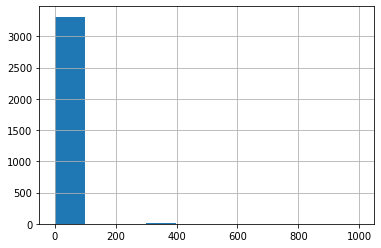

In [21]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count